Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

Epoch - 1


Training: 100%|██████████| 2320/2320 [13:52<00:00,  2.79it/s]


Train Accuracy: 0.4719635160190278      Train Loss: 1.8061794317231097


Evaluating: 100%|██████████| 15875/15875 [02:39<00:00, 99.46it/s]


F1 Score: 0.6377272175871356
Epoch - 2


Training: 100%|██████████| 2320/2320 [13:50<00:00,  2.80it/s]


Train Accuracy: 0.6595905172478023      Train Loss: 0.9230797075313227


Evaluating: 100%|██████████| 15875/15875 [02:39<00:00, 99.69it/s]


F1 Score: 0.6709912794246637
Epoch - 3


Training: 100%|██████████| 2320/2320 [13:49<00:00,  2.80it/s]


Train Accuracy: 0.7527959513638554      Train Loss: 0.5667230018671473


Evaluating: 100%|██████████| 15875/15875 [02:39<00:00, 99.77it/s] 


F1 Score: 0.6793462642492083
Epoch - 4


Training: 100%|██████████| 2320/2320 [13:49<00:00,  2.80it/s]


Train Accuracy: 0.8217364532166513      Train Loss: 0.36324043402705214


Evaluating: 100%|██████████| 15875/15875 [02:38<00:00, 99.86it/s] 


F1 Score: 0.6835403555997226
Epoch - 5


Training: 100%|██████████| 2320/2320 [13:49<00:00,  2.80it/s]


Train Accuracy: 0.863798876260889      Train Loss: 0.2522588363037734


Evaluating: 100%|██████████| 15875/15875 [02:39<00:00, 99.80it/s] 


F1 Score: 0.6809142118430395
Epoch - 6


Training: 100%|██████████| 2320/2320 [13:49<00:00,  2.80it/s]


Train Accuracy: 0.8958205049407894      Train Loss: 0.18014434465881565


Evaluating: 100%|██████████| 15875/15875 [02:39<00:00, 99.51it/s] 


F1 Score: 0.6739667192671752


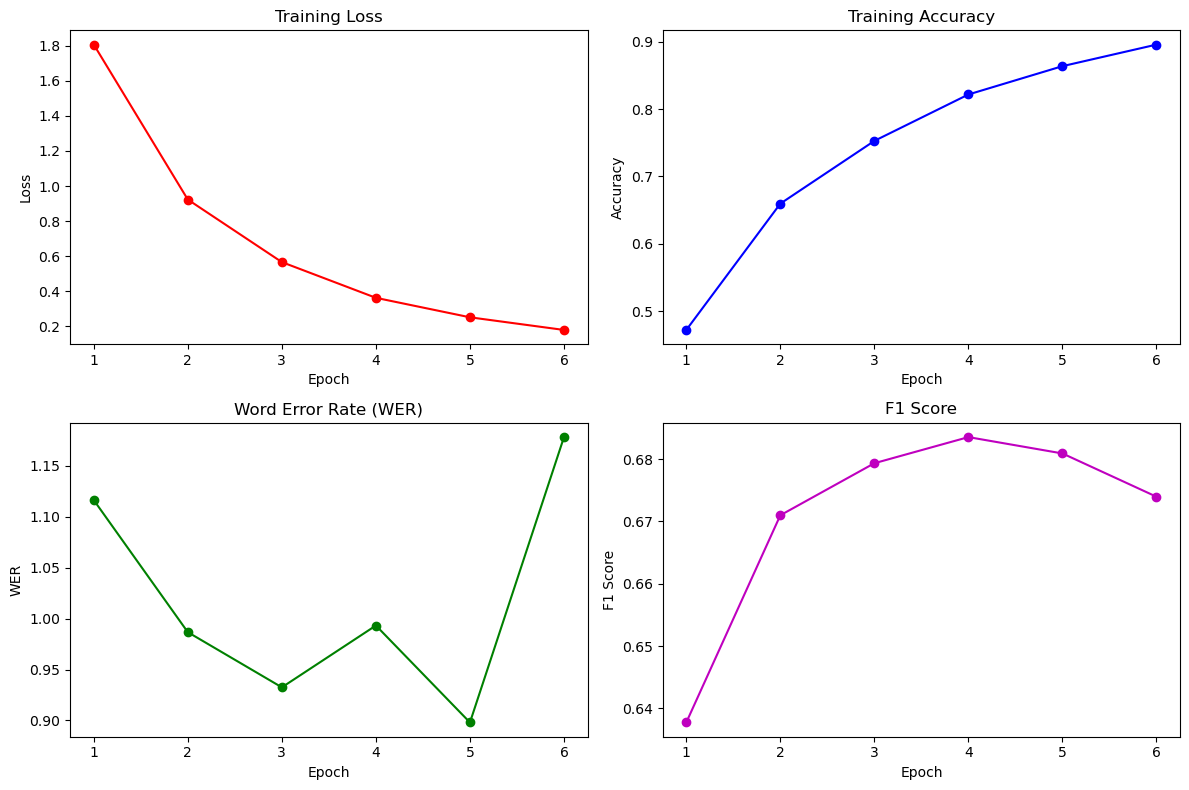

In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, AutoModelForQuestionAnswering, AutoTokenizer
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import os
from evaluate import load
import re
import string
from collections import Counter
import matplotlib.pyplot as plt

def extract_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    passage_list = []
    query_list = []
    response_list = []
    for topic in data['data']:
        for paragraph in topic['paragraphs']:
            passage = paragraph['context'].lower()
            for qa in paragraph['qas']:
                query = qa['question'].lower()
                for answer in qa['answers']:
                    answer_text = answer['text'].lower()
                    passage_list.append(passage)
                    query_list.append(query)
                    response_list.append({
                        'text': answer_text,
                        'answer_start': answer['answer_start'],
                        'answer_end': answer['answer_start'] + len(answer_text)
                    })
    return passage_list, query_list, response_list

class SQAD(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }

    def __len__(self):
        return len(self.encodings['input_ids'])

def add_start_and_end_positions(queries, contexts, answers, tokenizer, max_length, doc_stride = 128):
    start_positions = []
    end_positions = []
    encodings = tokenizer(queries, contexts, max_length = MAX_LENGTH,truncation=True,padding=True, return_offsets_mapping=False, stride = doc_stride)
    for idx, answer in enumerate(answers):
        ret_start = 0
        ret_end = 0
        answer_encoding_fast = tokenizer(answer['text'], max_length=max_length, truncation=True, padding=True)
        for a in range(len(encodings['input_ids'][idx]) - len(answer_encoding_fast['input_ids']) + 1):
            match = True
            for i in range(1, len(answer_encoding_fast['input_ids']) - 1):
                if answer_encoding_fast['input_ids'][i] != encodings['input_ids'][idx][a + i]:
                    match = False
                    break
            if match:
                ret_start = a + 1
                ret_end = a + i + 1
                break
        start_positions.append(ret_start)
        end_positions.append(ret_end)

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return encodings

def normalize_text(text):
    def remove_articles(txt):
        return re.sub(r'\b(a|an|the)\b', ' ', txt)

    def white_space_fix(txt):
        return ' '.join(txt.split())

    def remove_punc(txt):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in txt if ch not in exclude)

    def lower(txt):
        return txt.lower()

    return white_space_fix(remove_articles(remove_punc(lower(text))))

class QuestionAnsweringModel(nn.Module):
    def __init__(self, bert_base_model, device):
        super(QuestionAnsweringModel, self).__init__()
        self.bert = bert_base_model
        self.device = device
        self.to(device)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        start_logits, end_logits = outputs.start_logits, outputs.end_logits
        return start_logits, end_logits

    def train_epoch(self, dataloader, optimizer, scheduler):
        self.train()
        loss_values = []
        accuracy_values = []
        for batch in tqdm(dataloader, desc='Training'):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            start_positions = batch['start_positions'].to(self.device)
            end_positions = batch['end_positions'].to(self.device)
            output_start, output_end = self(input_ids=input_ids, attention_mask=attention_mask)
            loss = self.focal_loss(output_start, output_end, start_positions, end_positions, 1) #using gamma = 1
            loss_values.append(loss.item())
            loss.backward()
            optimizer.step()

            start_predictions = torch.argmax(output_start, dim=1)
            end_predictions = torch.argmax(output_end, dim=1)

            accuracy_values.append(((start_predictions == start_positions).sum()/len(start_predictions)).item())
            accuracy_values.append(((end_predictions == end_positions).sum()/len(end_predictions)).item())
        scheduler.step()
        return sum(accuracy_values)/len(accuracy_values), sum(loss_values)/len(loss_values)
    
    def focal_loss(self, start_logits, end_logits, start_positions, end_positions, gamma):
        softmax = nn.Softmax(dim=1)
        start_probs = softmax(start_logits)
        inv_start_probs = 1 - start_probs
        end_probs = softmax(end_logits)
        inv_end_probs = 1 - end_probs
        
        log_softmax = nn.LogSoftmax(dim=1)
        log_start_probs = log_softmax(start_logits)
        log_end_probs = log_softmax(end_logits)
        
        negative_log_likelihood = nn.NLLLoss()
        
        start_loss = negative_log_likelihood(torch.pow(inv_start_probs, gamma) * log_start_probs, start_positions)
        end_loss = negative_log_likelihood(torch.pow(inv_end_probs, gamma) * log_end_probs, end_positions)
        
        return (start_loss + end_loss) / 2
    
    def evaluate_model(self, dataloader, tokenizer):
        self.eval()
        f1_scores = []
        answer_list = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc='Evaluating'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                start_true_positions = batch['start_positions'].to(self.device)
                end_true_positions = batch['end_positions'].to(self.device)

                output_start, output_end = self(input_ids=input_ids, attention_mask=attention_mask)
                start_pred = torch.argmax(output_start, dim=1)
                end_pred = torch.argmax(output_end, dim=1)

                for i in range(input_ids.size(0)):
                    pred_answer = tokenizer.decode(input_ids[i][start_pred[i]:end_pred[i]+1])
                    true_answer = tokenizer.decode(input_ids[i][start_true_positions[i]:end_true_positions[i]+1])
                    answer_list.append([pred_answer, true_answer])
                    f1_scores.append(compute_f1_score(pred_answer, true_answer))
        pred_answers = [ans[0] if ans[0] else "$" for ans in answer_list]
        true_answers = [ans[1] if ans[1] else "$" for ans in answer_list]
        wer_score = wer_metric.compute(predictions=pred_answers, references=true_answers)
        avg_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0
        return avg_f1_score, wer_score
    
def compute_f1_score(pred_answer, true_answer):
    pred_tokens = normalize_text(pred_answer).split()
    true_tokens = normalize_text(true_answer).split()
    common_tokens = Counter(pred_tokens) & Counter(true_tokens)
    num_common = sum(common_tokens.values())
    if num_common == 0:
        return 0
    precision = 1.0 * num_common / len(pred_tokens)
    recall = 1.0 * num_common / len(true_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_data = 'spoken_train-v1.1.json'
test_data = 'spoken_test-v1.1.json'
train_passages, train_queries, train_response = extract_data(train_data)
test_passages, test_queries, test_response = extract_data(test_data)

MAX_LENGTH = 512
MODEL_PATH = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

train_encodings = add_start_and_end_positions(train_queries, train_passages, train_response, tokenizer, MAX_LENGTH)
valid_encodings = add_start_and_end_positions(test_queries,test_passages, test_response, tokenizer, MAX_LENGTH)

train_dataset = SQAD(train_encodings)
valid_dataset = SQAD(valid_encodings)

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=1)

bert_base_model = AutoModelForQuestionAnswering.from_pretrained(MODEL_PATH)
qa_model = QuestionAnsweringModel(bert_base_model, device)
optimizer = AdamW(qa_model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optimizer, gamma=0.9)

MODEL_SAVE_PATH = "qa_medium_model_scheduler.pt"


wer_metric = load("wer")
EPOCHS = 6
wer_scores = []
train_accuracies = []
train_losses = []
f1_scores = []

for epoch in range(EPOCHS):
    print(f'Epoch - {epoch + 1}')
    train_accuracy, train_loss = qa_model.train_epoch(train_data_loader, optimizer, scheduler)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f"Train Accuracy: {train_accuracy}      Train Loss: {train_loss}")
    avg_f1_score, wer_score  = qa_model.evaluate_model(valid_data_loader, tokenizer)
    f1_scores.append(avg_f1_score)
    print(f"F1 Score: {avg_f1_score}")
    wer_scores.append(wer_score)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
torch.save(qa_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'model_weights.pt'))
tokenizer.save_pretrained(MODEL_SAVE_PATH)
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='r')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs, wer_scores, marker='o', linestyle='-', color='g')
plt.title('Word Error Rate (WER)')
plt.xlabel('Epoch')
plt.ylabel('WER')

plt.subplot(2, 2, 4)
plt.plot(epochs, f1_scores, marker='o', linestyle='-', color='m')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()